Generated 5 polygons.
Global Bounds X: [-0.900, 0.900]
Global Bounds Y: [-0.619, 0.619]


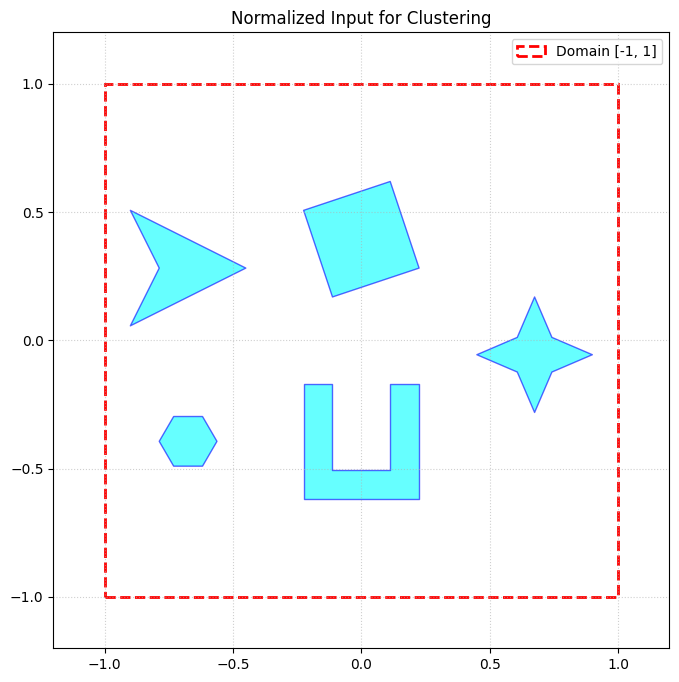

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

def get_raw_polygons():
    """
    Defines a list of 2D polygons (convex and non-convex).
    All polygons are ensured to be CCW.
    """
    # 1. Convex Hexagon (originally CW, now reversed)
    poly_convex_hexagon = np.array([
        [1.75, 1.57], [2.25, 1.57], [2.5, 2.0],
        [2.25, 2.43], [1.75, 2.43], [1.5, 2.0]
    ])
    
    # 2. Non-Convex "U" Shape (originally CW, now reversed)
    poly_nonconvex_u = np.array([
        [4.0, 1.0], [6.0, 1.0], [6.0, 3.0], [5.5, 3.0],
        [5.5, 1.5], [4.5, 1.5], [4.5, 3.0], [4.0, 3.0]
    ])
    
    # 3. Non-Convex "Dart" (already CCW)
    poly_nonconvex_dart = np.array([
        [1.0, 4.0], [3.0, 5.0], [1.0, 6.0], [1.5, 5.0]
    ])
    
    # 4. Convex Rectangle (already CCW)
    poly_convex_rect = np.array([
        [4.5, 4.5], [6.0, 5.0], [5.5, 6.5], [4.0, 6.0]
    ])
    
    # 5. Non-Convex Star (originally CW, now reversed)
    poly_nonconvex_star = np.array([
        [7.7, 3.8], [7.0, 3.5], [7.7, 3.2], [8.0, 2.5],
        [8.3, 3.2], [9.0, 3.5], [8.3, 3.8], [8.0, 4.5]
    ])
    
    return [
        poly_convex_hexagon,
        poly_nonconvex_u,
        poly_nonconvex_dart,
        poly_convex_rect,
        poly_nonconvex_star
    ]

def normalize_polygons(poly_list, domain_min=-0.9, domain_max=0.9):
    """
    Normalizes a list of polygons to fit exactly within [domain_min, domain_max]^2
    while preserving aspect ratio.
    """
    # 1. Find global bounds
    all_points = np.vstack(poly_list)
    min_coords = all_points.min(axis=0)
    max_coords = all_points.max(axis=0)

    # 2. Calculate Center
    center = (max_coords + min_coords) / 2.0

    # 3. Calculate Scale
    # We want the largest dimension (width or height) to fit in the target range
    target_span = domain_max - domain_min
    current_span = max_coords - min_coords
    max_current_dim = np.max(current_span)
    
    scale_factor = target_span / max_current_dim

    # 4. Apply Transformation
    normalized_list = []
    for p in poly_list:
        # Translate to 0, Scale, then Translate to center of target domain (if needed)
        # Here we center them at 0,0 which is the center of [-1, 1]
        p_norm = (p - center) * scale_factor
        normalized_list.append(p_norm)
        
    return normalized_list

def plot_polygons(poly_list, title="Polygons"):
    """
    Visualizes the polygons using Matplotlib.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    patches = []

    for i, p in enumerate(poly_list):
        # Create a Polygon patch
        polygon = MplPolygon(p, closed=True) 
        patches.append(polygon)

    # Add collection to plot
    p_collection = PatchCollection(patches, alpha=0.6, edgecolor='blue', facecolor='cyan')
    ax.add_collection(p_collection)

    # Setup domain view
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    
    # Draw the boundary box [-1, 1]
    rect = plt.Rectangle((-1, -1), 2, 2, fill=False, edgecolor='red', linestyle='--', linewidth=2, label='Domain [-1, 1]')
    ax.add_patch(rect)
    
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# 1. Get Data
raw_polygons = get_raw_polygons()

# 2. Normalize
polygons = normalize_polygons(raw_polygons)

# 3. Output Verification
print(f"Generated {len(polygons)} polygons.")
all_norm_points = np.vstack(polygons)
print(f"Global Bounds X: [{all_norm_points[:,0].min():.3f}, {all_norm_points[:,0].max():.3f}]")
print(f"Global Bounds Y: [{all_norm_points[:,1].min():.3f}, {all_norm_points[:,1].max():.3f}]")

# 4. Visualize
plot_polygons(polygons, "Normalized Input for Clustering")

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Optional

@dataclass
class SDFPrimitive:
    position: np.ndarray
    tensor: np.ndarray       # 2x2 matrix encoding direction uncertainty
    type: str                # "edge" or "vertex"
    
    # Edge-specific
    normal: Optional[np.ndarray] = None
    edge_vertices: Optional[Tuple[np.ndarray, np.ndarray]] = None
    
    # Vertex-specific
    fan_normals: Optional[Tuple[np.ndarray, np.ndarray]] = None
    convex: Optional[bool] = None

In [49]:
def normalize(v):
    """Normalize a vector."""
    n = np.linalg.norm(v)
    if n < 1e-10:
        return v
    return v / n


def cross_2d(a, b):
    """2D cross product (returns scalar z-component)."""
    return a[0] * b[1] - a[1] * b[0]


def rotate_90_cw(v):
    """Rotate vector 90 degrees clockwise."""
    return np.array([v[1], -v[0]])


def rotate_90_ccw(v):
    """Rotate vector 90 degrees counter-clockwise."""
    return np.array([-v[1], v[0]])

In [50]:
def stick_tensor(normal):
    """
    Create stick tensor from normal direction.
    
    Stick tensor has one dominant eigenvector (the normal direction).
    Eigenvalues: λ1 = 1, λ2 = 0
    """
    n = normalize(normal)
    return np.outer(n, n)


def wedge_tensor(normal1, normal2):
    """
    Create wedge tensor spanning two directions.
    
    For vertex fans: represents uncertainty between the two edge normals.
    """
    n1 = normalize(normal1)
    n2 = normalize(normal2)
    
    # Tensor is sum of the two stick tensors
    # This creates an ellipse spanning both directions
    T = np.outer(n1, n1) + np.outer(n2, n2)
    
    # Normalize so max eigenvalue is 1
    eigenvalues = np.linalg.eigvalsh(T)
    max_eig = np.max(eigenvalues)
    if max_eig > 1e-10:
        T = T / max_eig
    
    return T

In [51]:
def is_convex_vertex(v_prev, v_curr, v_next):
    """
    Check if vertex is convex assuming CCW winding.
    
    CCW polygon + left turn = convex vertex (exterior angle < 180°)
    CCW polygon + right turn = concave/reflex vertex (exterior angle > 180°)
    
    Left turn = positive cross product
    """
    edge_in = v_curr - v_prev
    edge_out = v_next - v_curr
    cross = cross_2d(edge_in, edge_out)
    return cross > 0

In [52]:
def extract_primitives_from_polygon(polygon: np.ndarray) -> List[SDFPrimitive]:
    """
    Extract SDFPrimitives from a single polygon.
    
    Assumes CCW vertex ordering.
    
    Args:
        polygon: (N, 2) array of vertices
        
    Returns:
        List of SDFPrimitive (N edges + N vertices = 2N primitives)
    """
    n = len(polygon)
    primitives = []
    
    # Compute all edge normals first (outward pointing for CCW polygon)
    edge_normals = []
    for i in range(n):
        v1 = polygon[i]
        v2 = polygon[(i + 1) % n]
        edge = v2 - v1
        # Rotate edge 90° CW to get outward normal
        normal = normalize(rotate_90_cw(edge))
        edge_normals.append(normal)
    
    # Create EDGE primitives
    for i in range(n):
        v1 = polygon[i]
        v2 = polygon[(i + 1) % n]
        
        midpoint = (v1 + v2) / 2.0
        normal = edge_normals[i]
        tensor = stick_tensor(normal)
        
        prim = SDFPrimitive(
            position=midpoint.copy(),
            tensor=tensor,
            type="edge",
            normal=normal.copy(),
            edge_vertices=(v1.copy(), v2.copy())
        )
        primitives.append(prim)
    
    # Create VERTEX primitives
    for i in range(n):
        v_prev = polygon[(i - 1) % n]
        v_curr = polygon[i]
        v_next = polygon[(i + 1) % n]
        
        # The two edge normals meeting at this vertex
        normal_before = edge_normals[(i - 1) % n]  # edge ending at v_curr
        normal_after = edge_normals[i]              # edge starting at v_curr
        
        convex = is_convex_vertex(v_prev, v_curr, v_next)
        tensor = wedge_tensor(normal_before, normal_after)
        
        prim = SDFPrimitive(
            position=v_curr.copy(),
            tensor=tensor,
            type="vertex",
            fan_normals=(normal_before.copy(), normal_after.copy()),
            convex=convex
        )
        primitives.append(prim)
    
    return primitives

In [53]:
def extract_all_primitives(polygons: List[np.ndarray]) -> List[SDFPrimitive]:
    """Extract primitives from a list of polygons."""
    all_primitives = []
    for polygon in polygons:
        all_primitives.extend(extract_primitives_from_polygon(polygon))
    return all_primitives

In [54]:
def plot_primitives(primitives: List[SDFPrimitive], 
                    polygons: List[np.ndarray] = None,
                    arrow_scale: float = 0.1):
    """Visualize primitives with their normals."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw polygons
    if polygons is not None:
        for poly in polygons:
            closed = np.vstack([poly, poly[0]])
            ax.plot(closed[:, 0], closed[:, 1], 'b-', linewidth=2)
    
    # Draw primitives
    for prim in primitives:
        pos = prim.position
        
        if prim.type == "edge":
            # Green square, arrow shows outward normal
            ax.scatter([pos[0]], [pos[1]], c='green', s=60, marker='s', zorder=5)
            end = pos + prim.normal * arrow_scale
            ax.arrow(pos[0], pos[1], prim.normal[0]*arrow_scale, prim.normal[1]*arrow_scale,
                    head_width=0.02, head_length=0.01, fc='green', ec='green')
        
        elif prim.type == "vertex":
            # Red circle (convex) or orange triangle (concave)
            color = 'red' if prim.convex else 'orange'
            marker = 'o' if prim.convex else '^'
            ax.scatter([pos[0]], [pos[1]], c=color, s=80, marker=marker, zorder=5)
            
            # Draw fan normals
            n1, n2 = prim.fan_normals
            scale = arrow_scale * 0.7
            
            if prim.convex:
                # Outward fans
                ax.arrow(pos[0], pos[1], n1[0]*scale, n1[1]*scale,
                        head_width=0.015, head_length=0.008, fc=color, ec=color, alpha=0.7)
                ax.arrow(pos[0], pos[1], n2[0]*scale, n2[1]*scale,
                        head_width=0.015, head_length=0.008, fc=color, ec=color, alpha=0.7)
            else:
                # Inward fans (flip direction)
                ax.arrow(pos[0], pos[1], -n1[0]*scale, -n1[1]*scale,
                        head_width=0.015, head_length=0.008, fc=color, ec=color, alpha=0.7)
                ax.arrow(pos[0], pos[1], -n2[0]*scale, -n2[1]*scale,
                        head_width=0.015, head_length=0.008, fc=color, ec=color, alpha=0.7)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title('SDF Primitives')
    plt.show()
    
    return fig, ax


def plot_hyperplanes(weights: np.ndarray, biases: np.ndarray,
                     polygons: List[np.ndarray] = None):
    """Visualize layer 1 hyperplanes."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw polygons
    if polygons is not None:
        for poly in polygons:
            closed = np.vstack([poly, poly[0]])
            ax.plot(closed[:, 0], closed[:, 1], 'b-', linewidth=2)
    
    # Draw each hyperplane
    for i, (w, b) in enumerate(zip(weights, biases)):
        if np.linalg.norm(w) < 1e-10:
            continue
        
        # Line: w[0]*x + w[1]*y + b = 0
        if abs(w[1]) > abs(w[0]):
            x = np.linspace(-1.5, 1.5, 100)
            y = -(w[0] * x + b) / w[1]
        else:
            y = np.linspace(-1.5, 1.5, 100)
            x = -(w[1] * y + b) / w[0]
        
        mask = (x >= -1.2) & (x <= 1.2) & (y >= -1.2) & (y <= 1.2)
        if mask.sum() > 1:
            ax.plot(x[mask], y[mask], '-', linewidth=0.8, alpha=0.6)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Layer 1 Hyperplanes ({len(weights)} neurons)')
    plt.show()
    
    return fig, ax

Polygons: 5
Total primitives: 60
  Edges: 30
  Vertices: 30
    Convex: 23
    Concave: 7


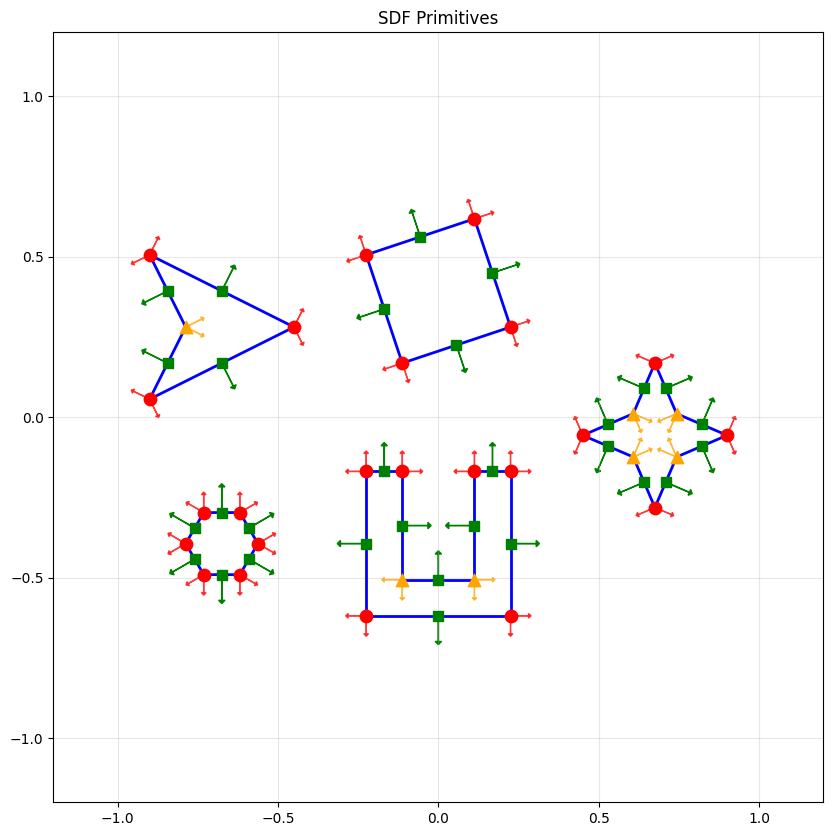

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'SDF Primitives'}>)

In [55]:
# Extract primitives
primitives = extract_all_primitives(polygons)

print(f"Polygons: {len(polygons)}")
print(f"Total primitives: {len(primitives)}")
print(f"  Edges: {sum(1 for p in primitives if p.type == 'edge')}")
print(f"  Vertices: {sum(1 for p in primitives if p.type == 'vertex')}")
print(f"    Convex: {sum(1 for p in primitives if p.type == 'vertex' and p.convex)}")
print(f"    Concave: {sum(1 for p in primitives if p.type == 'vertex' and not p.convex)}")

# Visualize primitives
plot_primitives(primitives, polygons, arrow_scale=0.08)